In [5]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import io
import pickle
import json

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

from uNetModel import *
from encoder import *
from LayerNormUnet import *

In [2]:
# For this cell used same code from PyTorch notebook in assignment 2 of Stanford's CS231n Spring 2018 offering
preprocessData = False # To preprocess data set this to True
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    dtype = torch.float32

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cuda


In [3]:
# For this cell, code belongs to [1]. Minor changes made to accomodate to our use 
# (Using PyTorch instead of Keras/tensorflow)
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
PATH = './stage1_train/'
epsilon = 1e-12 #For numerical stability

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 1
random.seed = seed
np.random.seed = seed

In [4]:
# Opening up json file that contains preprocessed images
with open('processedData.json') as f:
    data = json.load(f)

X_train = np.array(data['X_train'])
Y_train = np.array(data['Y_train'])
X_val = np.array(data['X_val'])
Y_val = np.array(data['Y_val'])
X_test = np.array(data['X_test'])
Y_test = np.array(data['Y_test'])

print('Shape of X_train = ', X_train.shape)
print('Shape of Y_train = ', Y_train.shape)
print('Shape of X_val = ', X_val.shape)
print('Shape of Y_val = ', Y_val.shape)
print('Shape of X_test = ', X_test.shape)
print('Shape of Y_test = ', Y_test.shape)

Shape of X_train =  (402, 3, 128, 128)
Shape of Y_train =  (402, 1, 128, 128)
Shape of X_val =  (134, 3, 128, 128)
Shape of Y_val =  (134, 1, 128, 128)
Shape of X_test =  (134, 3, 128, 128)
Shape of Y_test =  (134, 1, 128, 128)


In [22]:
def calc_percentage_correct(preds, y):
    D = 1
    for i in range(len(preds.shape)):
        D *= preds.shape[i]
    preds = preds.view(preds.shape[0], -1)
    y = y.view(y.shape[0], -1)
    count = (preds==y).sum()
    return float(count)/float(D)

In [91]:
def showVisualComparisons(y, pred):
    y_reshaped = np.transpose(y, (1,2,0))
    pred_reshaped = np.transpose(pred, (1,2,0))
    imshow(np.squeeze(np.uint8(y_reshaped)))
    plt.show()
    imshow(np.squeeze(np.uint8(pred_reshaped)))
    plt.show()

In [93]:
def calculatePerformance(X_perf, Y_perf, model, mini_batch_size =  64, visual = False):
    D = 1
    for i in range(len(Y_perf.shape)):
        D *= Y_perf.shape[i]
    model.eval() #set model to evaluation mode
    numCorrect = 0
    num_batches = int(X_perf.shape[0]/mini_batch_size)
    num_remaining = X_perf.shape[0] - num_batches *mini_batch_size
    with torch.no_grad():
        for i in range(num_batches):
            x = torch.from_numpy(X_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :])
            y = torch.from_numpy(Y_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :]).type(torch.cuda.FloatTensor)
            x = x.to(device = device, dtype = dtype)
            preds = model(x)
            preds = (preds > 0.5).type(preds.type())
            numCorrect += (preds==y).sum()
        x = torch.from_numpy(X_perf[num_batches*mini_batch_size:, :, :, :])
        y = torch.from_numpy(Y_perf[num_batches*mini_batch_size:, :, :, :]).type(torch.cuda.FloatTensor)
        x = x.to(device = device, dtype = dtype)
        preds = model(x)
        preds = (preds > 0.5).type(preds.type())
        if visual:
            ix = np.random.randint((num_batches*mini_batch_size), X_perf.shape[0])
            showVisualComparisons(Y_perf[ix, :, :, :], preds[(ix - (num_batches*mini_batch_size)), :, :, :].cpu().numpy())
        numCorrect += (preds==y).sum()
    return float(numCorrect)/float(D)

In [80]:
def trainModel(model, x_train, y_train, optimizer, epochs = 1, mini_batch_size = 64, noVal = False):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    T = 0
    num_batches = int(len(x_train)/mini_batch_size)
    num_remaining = len(x_train) - num_batches *mini_batch_size
    loss_history = []
    for e in range(epochs):
        for t in range(num_batches):
            rand_indices = np.random.choice(len(x_train), mini_batch_size)
            x = torch.from_numpy(x_train[rand_indices, :, :, :])
            y = torch.from_numpy(y_train[rand_indices, :, :, :])
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = F.binary_cross_entropy(preds, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if T % print_every == 0:
                currLoss = loss.item()
                loss_history.append(currLoss)
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, currLoss))
            if (num_remaining <= 0 and t == (num_batches -1)):
                percentCorrect = calculatePerformance(x_train, y_train, model)
                print('Train percent correct at epoch %d is %.4f' % (e, percentCorrect))
                if (noVal == False):
                    percentCorrect = calculatePerformance(X_val, Y_val, model)
                    print('Val percent correct at epoch %d is %.4f' % (e, percentCorrect))
            T +=1
        if num_remaining > 0:
            rand_indices = np.random.choice(len(x_train), num_remaining)
            x = torch.from_numpy(x_train[rand_indices, :, :, :])
            y = torch.from_numpy(y_train[rand_indices, :, :, :])
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = F.binary_cross_entropy(preds, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            if T % print_every == 0:
                currLoss = loss.item()
                loss_history.append(currLoss)
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, num_batches, currLoss))
            percentCorrect = calculatePerformance(x_train, y_train, model)
            print('Train percent correct at epoch %d is %.4f' % (e, percentCorrect))
            if (noVal == False):
                percentCorrect = calculatePerformance(X_val, Y_val, model)
                print('Val percent correct at epoch %d is %.4f' % (e, percentCorrect))
            T +=1
    return calculatePerformance(x_train, y_train, model),loss_history

In [86]:
x_train = X_train[:50,:,:,:]
y_train = Y_train[:50, :,:,:]
print_every = 1
bestPerf = -1
bestLossHistory = None
lossHistories = {}
print_every = 1
bestModel = None
bestLoss = 10000
lrUsed = 0
lrs = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
for lr in lrs:
    layerNormModel = LayerNormUNet()
    optimizer = optim.Adam(layerNormModel.parameters(), lr = lr)
    modelPerf, lossHistory = trainModel(layerNormModel, x_train, y_train, optimizer, epochs = 25, noVal = True)
    lossHistories[str(lr)] = lossHistory
    if lossHistory[len(lossHistory)-1] < bestLoss:
        bestLoss = lossHistory[len(lossHistory)-1]
        bestPerf = modelPerf
        bestLossHistory = lossHistory
        bestModel = layerNormModel
        lrUsed = lr

Epoch 0, Iteration 0, loss = 0.9487
Train percent correct at epoch 0 is 0.5069
Epoch 1, Iteration 0, loss = 0.7639
Train percent correct at epoch 1 is 0.6404
Epoch 2, Iteration 0, loss = 0.6331
Train percent correct at epoch 2 is 0.7845
Epoch 3, Iteration 0, loss = 0.5877
Train percent correct at epoch 3 is 0.7997
Epoch 4, Iteration 0, loss = 0.5869
Train percent correct at epoch 4 is 0.8100
Epoch 5, Iteration 0, loss = 0.5655
Train percent correct at epoch 5 is 0.8193
Epoch 6, Iteration 0, loss = 0.5882
Train percent correct at epoch 6 is 0.8270
Epoch 7, Iteration 0, loss = 0.5178
Train percent correct at epoch 7 is 0.8326
Epoch 8, Iteration 0, loss = 0.5358
Train percent correct at epoch 8 is 0.8367
Epoch 9, Iteration 0, loss = 0.5102
Train percent correct at epoch 9 is 0.8408
Epoch 10, Iteration 0, loss = 0.5286
Train percent correct at epoch 10 is 0.8462
Epoch 11, Iteration 0, loss = 0.5285
Train percent correct at epoch 11 is 0.8527
Epoch 12, Iteration 0, loss = 0.5092
Train perce

Epoch 3, Iteration 0, loss = 0.7514
Train percent correct at epoch 3 is 0.6159
Epoch 4, Iteration 0, loss = 0.7544
Train percent correct at epoch 4 is 0.6161
Epoch 5, Iteration 0, loss = 0.7539
Train percent correct at epoch 5 is 0.6162
Epoch 6, Iteration 0, loss = 0.7519
Train percent correct at epoch 6 is 0.6163
Epoch 7, Iteration 0, loss = 0.7559
Train percent correct at epoch 7 is 0.6165
Epoch 8, Iteration 0, loss = 0.7650
Train percent correct at epoch 8 is 0.6167
Epoch 9, Iteration 0, loss = 0.7542
Train percent correct at epoch 9 is 0.6169
Epoch 10, Iteration 0, loss = 0.7464
Train percent correct at epoch 10 is 0.6170
Epoch 11, Iteration 0, loss = 0.7544
Train percent correct at epoch 11 is 0.6172
Epoch 12, Iteration 0, loss = 0.7467
Train percent correct at epoch 12 is 0.6174
Epoch 13, Iteration 0, loss = 0.7506
Train percent correct at epoch 13 is 0.6175
Epoch 14, Iteration 0, loss = 0.7439
Train percent correct at epoch 14 is 0.6177
Epoch 15, Iteration 0, loss = 0.7565
Train

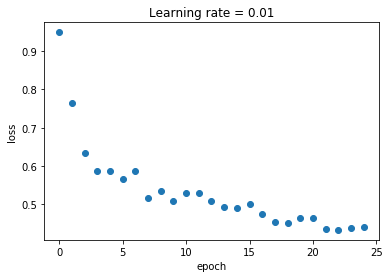

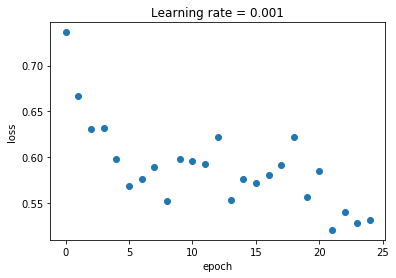

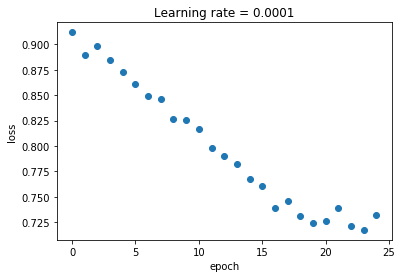

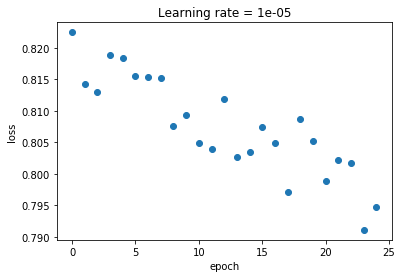

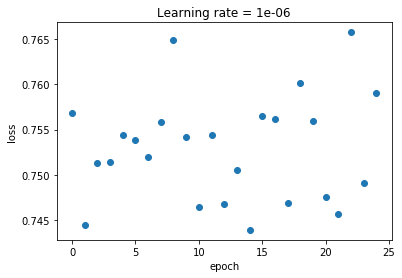

Lowest loss =  0.440475195646286


In [87]:
# Let us take a look at the loss history to verify training
for lr, lossHist in lossHistories.items():
    plt.plot((np.arange(len(lossHist))),lossHist, 'o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Learning rate = '+ lr)
    plt.show()
print('Lowest loss = ', str(bestLossHistory[len(bestLossHistory)-1]))

### Insight:
Looks like best training occurs at about 1e-2 so will explore randomly about this point.

In [97]:
x_train = X_train[:50,:,:,:]
y_train = Y_train[:50, :,:,:]
print_every = 1
bestPerf = -1
bestLossHistory = None
lossHistories = {}
print_every = 1
bestModel = None
bestLoss = 10000
lrUsed = 0
lrs = [0.023929554017127243] # Best result from prev. random search
for i in range(4):
    lrs.append(.1*np.random.random())
for lr in lrs:
    print('About to try lr = ', str(lr))
    layerNormModel = LayerNormUNet()
    optimizer = optim.Adam(layerNormModel.parameters(), lr = lr)
    modelPerf, lossHistory = trainModel(layerNormModel, x_train, y_train, optimizer, epochs = 25, noVal = True)
    lossHistories[str(lr)] = lossHistory
    if lossHistory[len(lossHistory)-1] < bestLoss:
        bestLoss = lossHistory[len(lossHistory)-1]
        bestPerf = modelPerf
        bestLossHistory = lossHistory
        bestModel = layerNormModel
        lrUsed = lr

About to try lr =  0.023929554017127243
Epoch 0, Iteration 0, loss = 0.8264
Train percent correct at epoch 0 is 0.5758
Epoch 1, Iteration 0, loss = 0.6756
Train percent correct at epoch 1 is 0.6862
Epoch 2, Iteration 0, loss = 0.5957
Train percent correct at epoch 2 is 0.7278
Epoch 3, Iteration 0, loss = 0.5583
Train percent correct at epoch 3 is 0.7568
Epoch 4, Iteration 0, loss = 0.5622
Train percent correct at epoch 4 is 0.8011
Epoch 5, Iteration 0, loss = 0.5762
Train percent correct at epoch 5 is 0.8023
Epoch 6, Iteration 0, loss = 0.5753
Train percent correct at epoch 6 is 0.8048
Epoch 7, Iteration 0, loss = 0.4829
Train percent correct at epoch 7 is 0.8185
Epoch 8, Iteration 0, loss = 0.5100
Train percent correct at epoch 8 is 0.8314
Epoch 9, Iteration 0, loss = 0.5137
Train percent correct at epoch 9 is 0.8355
Epoch 10, Iteration 0, loss = 0.4793
Train percent correct at epoch 10 is 0.8545
Epoch 11, Iteration 0, loss = 0.4845
Train percent correct at epoch 11 is 0.8883
Epoch 12

Epoch 0, Iteration 0, loss = 0.6713
Train percent correct at epoch 0 is 0.8361
Epoch 1, Iteration 0, loss = 0.6498
Train percent correct at epoch 1 is 0.8489
Epoch 2, Iteration 0, loss = 0.5245
Train percent correct at epoch 2 is 0.8546
Epoch 3, Iteration 0, loss = 0.5327
Train percent correct at epoch 3 is 0.8571
Epoch 4, Iteration 0, loss = 0.5068
Train percent correct at epoch 4 is 0.8620
Epoch 5, Iteration 0, loss = 0.4873
Train percent correct at epoch 5 is 0.8716
Epoch 6, Iteration 0, loss = 0.4772
Train percent correct at epoch 6 is 0.8818
Epoch 7, Iteration 0, loss = 0.4409
Train percent correct at epoch 7 is 0.8924
Epoch 8, Iteration 0, loss = 0.4396
Train percent correct at epoch 8 is 0.9000
Epoch 9, Iteration 0, loss = 0.4208
Train percent correct at epoch 9 is 0.9054
Epoch 10, Iteration 0, loss = 0.3981
Train percent correct at epoch 10 is 0.9094
Epoch 11, Iteration 0, loss = 0.3601
Train percent correct at epoch 11 is 0.9125
Epoch 12, Iteration 0, loss = 0.3436
Train perce

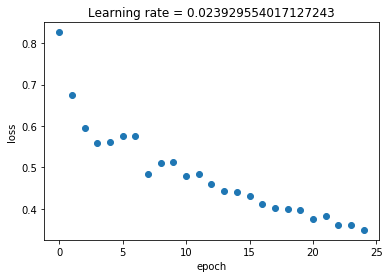

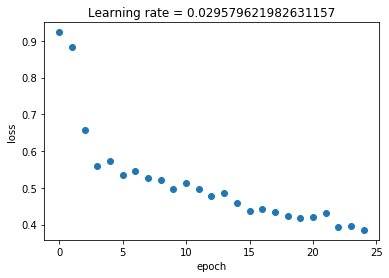

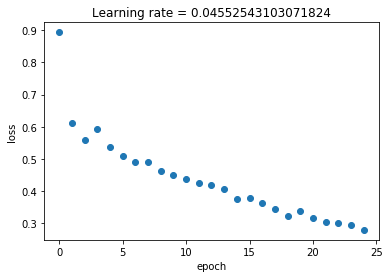

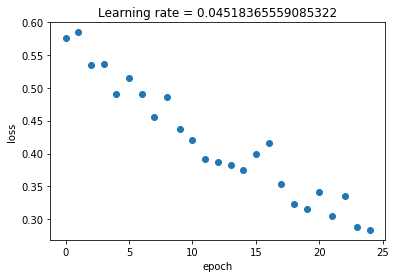

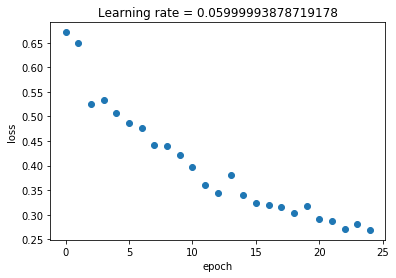

Lowest loss =  0.2691299021244049


In [98]:
# Let us take a look at the loss history to verify training
for lr, lossHist in lossHistories.items():
    plt.plot((np.arange(len(lossHist))),lossHist, 'o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Learning rate = '+ lr)
    plt.show()
print('Lowest loss = ', str(bestLossHistory[len(bestLossHistory)-1]))

Epoch 0, Iteration 0, loss = 0.7508
Epoch 0, Iteration 1, loss = 0.6084
Epoch 0, Iteration 2, loss = 0.6009
Epoch 0, Iteration 3, loss = 0.5214
Epoch 0, Iteration 4, loss = 0.5101
Epoch 0, Iteration 5, loss = 0.5105
Epoch 0, Iteration 6, loss = 0.4984
Train percent correct at epoch 0 is 0.8676
Epoch 1, Iteration 0, loss = 0.4610
Epoch 1, Iteration 1, loss = 0.4722
Epoch 1, Iteration 2, loss = 0.4621
Epoch 1, Iteration 3, loss = 0.4112
Epoch 1, Iteration 4, loss = 0.4164
Epoch 1, Iteration 5, loss = 0.3934
Epoch 1, Iteration 6, loss = 0.4169
Train percent correct at epoch 1 is 0.9041
Epoch 2, Iteration 0, loss = 0.3493
Epoch 2, Iteration 1, loss = 0.3543
Epoch 2, Iteration 2, loss = 0.3201
Epoch 2, Iteration 3, loss = 0.3323
Epoch 2, Iteration 4, loss = 0.3207
Epoch 2, Iteration 5, loss = 0.3058
Epoch 2, Iteration 6, loss = 0.2869
Train percent correct at epoch 2 is 0.9141
Epoch 3, Iteration 0, loss = 0.2863
Epoch 3, Iteration 1, loss = 0.2826
Epoch 3, Iteration 2, loss = 0.2836
Epoch 3

Epoch 27, Iteration 3, loss = 0.0979
Epoch 27, Iteration 4, loss = 0.0982
Epoch 27, Iteration 5, loss = 0.0996
Epoch 27, Iteration 6, loss = 0.0945
Train percent correct at epoch 27 is 0.9711
Epoch 28, Iteration 0, loss = 0.0849
Epoch 28, Iteration 1, loss = 0.1005
Epoch 28, Iteration 2, loss = 0.0971
Epoch 28, Iteration 3, loss = 0.0792
Epoch 28, Iteration 4, loss = 0.0828
Epoch 28, Iteration 5, loss = 0.0908
Epoch 28, Iteration 6, loss = 0.0914
Train percent correct at epoch 28 is 0.9710
Epoch 29, Iteration 0, loss = 0.0873
Epoch 29, Iteration 1, loss = 0.0949
Epoch 29, Iteration 2, loss = 0.0853
Epoch 29, Iteration 3, loss = 0.0776
Epoch 29, Iteration 4, loss = 0.0931
Epoch 29, Iteration 5, loss = 0.0874
Epoch 29, Iteration 6, loss = 0.0819
Train percent correct at epoch 29 is 0.9720
Epoch 30, Iteration 0, loss = 0.0877
Epoch 30, Iteration 1, loss = 0.0834
Epoch 30, Iteration 2, loss = 0.0850
Epoch 30, Iteration 3, loss = 0.0887
Epoch 30, Iteration 4, loss = 0.0838
Epoch 30, Iterati

Epoch 54, Iteration 4, loss = 0.0674
Epoch 54, Iteration 5, loss = 0.0636
Epoch 54, Iteration 6, loss = 0.0475
Train percent correct at epoch 54 is 0.9788
Epoch 55, Iteration 0, loss = 0.0667
Epoch 55, Iteration 1, loss = 0.0510
Epoch 55, Iteration 2, loss = 0.0587
Epoch 55, Iteration 3, loss = 0.0607
Epoch 55, Iteration 4, loss = 0.0637
Epoch 55, Iteration 5, loss = 0.0637
Epoch 55, Iteration 6, loss = 0.0672
Train percent correct at epoch 55 is 0.9782
Epoch 56, Iteration 0, loss = 0.0575
Epoch 56, Iteration 1, loss = 0.0610
Epoch 56, Iteration 2, loss = 0.0639
Epoch 56, Iteration 3, loss = 0.0719
Epoch 56, Iteration 4, loss = 0.0680
Epoch 56, Iteration 5, loss = 0.0604
Epoch 56, Iteration 6, loss = 0.0545
Train percent correct at epoch 56 is 0.9791
Epoch 57, Iteration 0, loss = 0.0506
Epoch 57, Iteration 1, loss = 0.0648
Epoch 57, Iteration 2, loss = 0.0774
Epoch 57, Iteration 3, loss = 0.0642
Epoch 57, Iteration 4, loss = 0.0671
Epoch 57, Iteration 5, loss = 0.0684
Epoch 57, Iterati

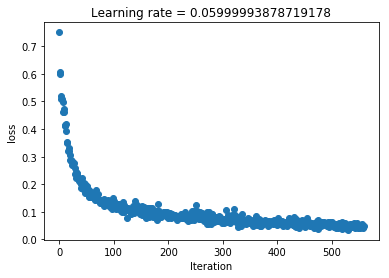

In [105]:
layerNormModel = LayerNormUNet()
optimizer = optim.Adam(layerNormModel.parameters(), lr = lrUsed)
modelPerf, lossHistory = trainModel(layerNormModel, X_train, Y_train, optimizer, epochs = 80, noVal = True)
plt.plot((np.arange(len(lossHistory))),lossHistory, 'o')
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Learning rate = '+ str(lrUsed))
plt.show()

/home/shared/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


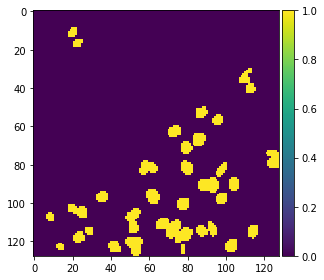

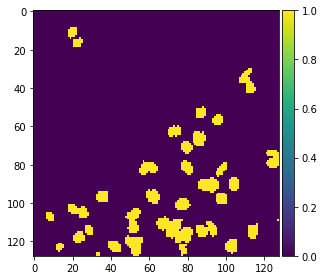

Percentage correct on train set =  0.9827721439190765


In [106]:
# Let us visualize how different our predicted masks are
print('Percentage correct on train set = ', calculatePerformance(X_train, Y_train, layerNormModel, visual = True))

/home/shared/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


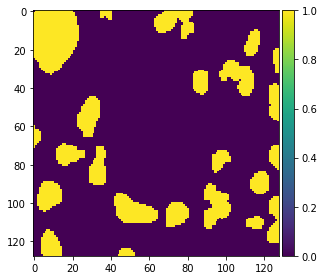

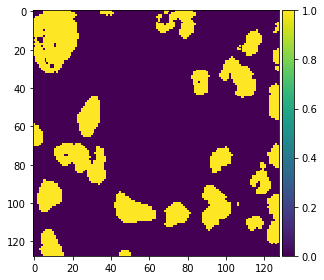

Percentage correct on val set =  0.9523707147854478


In [107]:
print('Percentage correct on val set = ', calculatePerformance(X_val, Y_val, layerNormModel, visual = True))

In [108]:
# Let us now compare to baseline model
baselineModel = torch.load('baselineModel')
print('Percentage correct on train set = ', calculatePerformance(X_train, Y_train, baselineModel, visual = False))
print('Percentage correct on val set = ', calculatePerformance(X_val, Y_val, baselineModel, visual = False))

Percentage correct on train set =  0.9685116288673818
Percentage correct on val set =  0.9599504613164646


In [109]:
torch.save(layerNormModel, 'layerNormModel')

In [112]:
layerNormModel = torch.load('layerNormModel')

# References
[1] Amdal-Saevik, K. (2018). Keras U-Net starter - LB 0.277. 
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855/code

[2] Ho, D. J., Fu, C., Salama, P., Dunn, K. W., and Delp, E. J. (2017, July). Nuclei Segmentation of Fluorescence Microscopy Images Using Three Dimensional Convolutional Neural Networks. In Computer Vision and Pattern Recognition Workshops (CVPRW), 2017 IEEE Conference on (pp. 834-842). IEEE.

[3] Kakade, A., and Dumbali, J. (2018, February). Identification of nerve in ultrasound images using U-net architecture. In 2018 International Conference on Communication information and Computing Technology (ICCICT) (pp. 1-6). IEEE.

[4] Li, X., Chen, H., Qi, X., Dou, Q., Fu, C. W., and Heng, P. A. (2017). H-DenseUNet: Hybrid densely connected UNet for liver and liver tumor segmentation from CT volumes. arXiv preprint arXiv:1709.07330.

[5] Ronneberger, O., Fischer, P., and Brox, T. 
(2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

[6] Pearce, C. Convolutional (2017). Neural Networks and the Analysis of Cancer Imagery.

[7] Imagenet. https://patrykchrabaszcz.github.io/Imagenet32/